Copyright 2022 Masamichi J. Miyama

In [1]:
import numpy as np
import optuna
from tqdm import tqdm

最もシンプルな使い方

https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/001_first.html

In [2]:
# 目的関数の定義
def objective(trial):
    # -10から10までの値を取るfloat変数の定義（最適化対象のパラメタ）
    # hyperoptと異なるのはオラクルたる目的関数側で変数定義をやる点？
    x = trial.suggest_float("x", -10, 10)

    return (x - 2) ** 2

上の例では`float`型のパラメタを扱ったがそれ以外にも整数値、カテゴリ変数など色々使える。探索空間の指定の仕方等、詳しくは下記URLを参照

https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html

In [3]:
# 最適化プロジェクトの定義
study = optuna.create_study()
# 最適化実行
study.optimize(objective, n_trials=100)

[I 2022-06-22 13:17:22,976] A new study created in memory with name: no-name-322910c1-247e-498c-a6f7-4ccb5770c6aa
[I 2022-06-22 13:17:22,980] Trial 0 finished with value: 24.2610954717778 and parameters: {'x': -2.925555346534825}. Best is trial 0 with value: 24.2610954717778.
[I 2022-06-22 13:17:22,981] Trial 1 finished with value: 82.25738503635753 and parameters: {'x': -7.069585714703706}. Best is trial 0 with value: 24.2610954717778.
[I 2022-06-22 13:17:22,983] Trial 2 finished with value: 90.2835428792137 and parameters: {'x': -7.501765250689669}. Best is trial 0 with value: 24.2610954717778.
[I 2022-06-22 13:17:22,984] Trial 3 finished with value: 5.3670348220213135 and parameters: {'x': -0.3166861725363912}. Best is trial 3 with value: 5.3670348220213135.
[I 2022-06-22 13:17:22,985] Trial 4 finished with value: 0.3897477215253496 and parameters: {'x': 1.3757022172669924}. Best is trial 4 with value: 0.3897477215253496.
[I 2022-06-22 13:17:22,988] Trial 5 finished with value: 10.9

In [4]:
# 最小値の表示
best_params = study.best_params
found_x = best_params["x"]
print(f"Found x: {found_x}, (x - 2)^2: {(found_x - 2) ** 2}")

Found x: 2.0004055331419943, (x - 2)^2: 1.6445712925578422e-07


探索の経過の可視化 (**Plotlyパッケージをインストール必要**)

https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html

In [5]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

バッチ最適化

基本的にはAsk-and-Tellインターフェースという対話的な利用の一ユースケースとしてバッチ最適化がある。たとえば、観山が困っていたパラメタ側に関する制約を守らせるためのサンプリングを事前にして、満たす入力値とこれに対する評価値のみをOptunaに伝えたいときもおそらくこの対話インターフェースを使えばよさそう。

https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/009_ask_and_tell.html

In [7]:
# バッチでパラメタを受け取って値を返す目的関数
# バッチ最適化というか対話的にOptunaを使う場合には目的関数内でパラメタを定義しないみたい
def batched_objective(xs: np.ndarray, ys: np.ndarray):
    return xs ** 2 + ys

In [8]:
# バッチサイズ
batch_size = 10
# 問い合わせ回数
num_query = 10
study = optuna.create_study()

X = []
Y = []

for _ in tqdm(range(num_query)):
    # create batch
    trial_ids = []
    x_batch = []
    y_batch = []

    # バッチサイズ分だけデータを作る
    for _ in range(batch_size):
        # Optunaにぶち込むためのデータ形式を作る
        trial = study.ask()
        trial_ids.append(trial.number)
        # ここでパラメタの定義と探索空間を指定
        x_batch.append(trial.suggest_float("x", -10, 10))
        y_batch.append(trial.suggest_float("y", -10, 10))

    # 現在のバッチに対する評価値をオラクルに問い合わせる
    x_batch = np.array(x_batch)
    y_batch = np.array(y_batch)
    objectives = batched_objective(x_batch, y_batch)
    X.extend(x_batch)
    Y.extend(y_batch)

    # 問い合わせ結果をOptunaに伝える
    for trial_id, objective in zip(trial_ids, objectives):
        study.tell(trial_id, objective)

[I 2022-06-22 13:21:00,418] A new study created in memory with name: no-name-a2983e11-c652-4946-9c0e-54848aa678e1
100%|██████████| 10/10 [00:00<00:00, 17.82it/s]


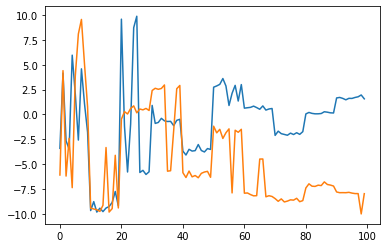

In [12]:
import matplotlib.pyplot as plt

plt.plot(X)
plt.plot(Y)

In [24]:
# 最小値の表示
best_params = study.best_params
found_x = best_params["x"]
found_y = best_params["y"]
print(f"Found x: {found_x}, y: {found_y}, objective: {batched_objective(found_x, found_y)}")

Found x: 0.22177243177503503, y: -9.908083700605765, objective: -9.858900689110353


In [25]:
# 10個ずつ10回聞いたのでトライアル合計数としては100個分となる
# 割と1回の問い合わせバッチの中身が偏っている印象を受けるがアルゴリズムの選択を変えると挙動が変わるのかもしれない
plot_optimization_history(study)